In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
import seaborn as sns

sns.set_theme(style="darkgrid")
%load_ext lab_black

# New York City Airbnb Open Data

## Importing development data

Each row is an Airbnb listing in NYC, for 2019

- `id`: unique listing identifier
- `name`: name of the listing
- `host_id`: unique host id
- `host_name`: name of the host
- `neighborhood_group`: name of the neighborhood
- `neighborhhod`: name of the actual neighborhood
- `latitute`, `longitude`
- `room_type`: type of the room
- `price`: price per night in dollars (our target)
- `minimum_nights`: minimum nights requested by hosts
- `number_of_reviews`
- `last_review`: date of last review
- `reviews_per_month`: average number of reviews per month
- `calculated_host_listings_count`: amount of listings of the host
- `availability_365`: number of days when the listing is available for booking

In [73]:
def get_data(filepath):
    df = pd.read_csv(
        filepath,
        parse_dates=["last_review"],
    )
    df.reviews_per_month = df.reviews_per_month.fillna(0)
    return (
        df.drop("price", axis=1).copy(),
        df[["price"]].copy(),
    )


X_raw, y_raw = get_data("../datasets/NYC_Airbnb/development.csv")

In [74]:
X_raw.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,1,2,2019-05-26,0.92,3,351
1,3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,1,202,2019-05-27,3.31,2,263
2,17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,2,0,NaT,0.00,1,0
3,33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,2,4,2019-07-07,1.64,1,89
4,9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,3,16,2019-04-20,0.42,1,103


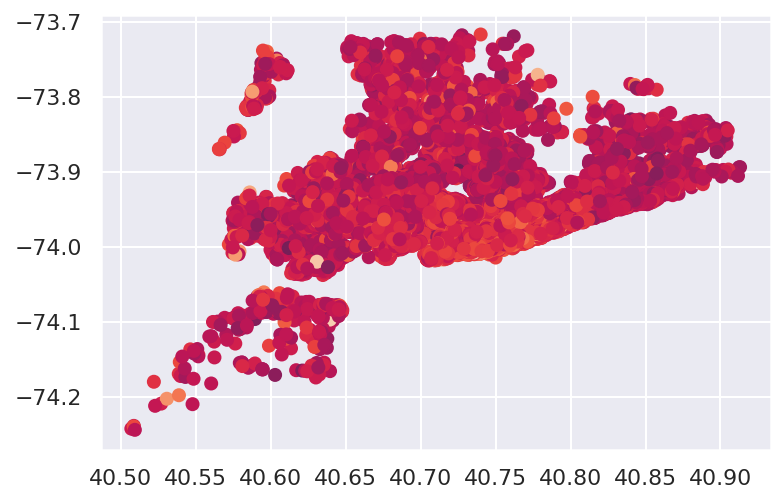

In [84]:
plt.scatter(X_raw.latitude, X_raw.longitude, c=np.log1p(y_raw.price))

## Train test split

Split before applying preprocessing to avoid contamination of global information such as min/max.

In [75]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, random_state=42
)

## Define cleaning pipeline

In [76]:
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        (
            "numerical",
            FunctionTransformer(),
            ["number_of_reviews", "availability_365", "latitude", "longitude"],
        ),
        (
            "categorical",
            OrdinalEncoder(),
            ["neighbourhood", "room_type", "neighbourhood_group"],
        ),
    ]
)

In [77]:
X_train = preprocessor.fit_transform(X_train_raw)
y_train = y_train_raw.to_numpy().reshape(-1)
X_test = preprocessor.fit_transform(X_test_raw)
y_test = y_test_raw.to_numpy().reshape(-1)
X_train[5:], y_train[5:]

(array([[ 17.     , 283.     ,  40.76012, ...,   4.     ,   1.     ,
           3.     ],
        [  2.     , 351.     ,  40.70726, ...,  73.     ,   0.     ,
           2.     ],
        [ 23.     ,   0.     ,  40.62448, ..., 184.     ,   0.     ,
           4.     ],
        ...,
        [  2.     ,   0.     ,  40.7631 , ..., 198.     ,   0.     ,
           2.     ],
        [  0.     , 340.     ,  40.73005, ..., 206.     ,   0.     ,
           2.     ],
        [273.     , 254.     ,  40.71137, ..., 211.     ,   1.     ,
           1.     ]]),
 array([ 45, 229,  89, ..., 150, 379, 100]))

## Regressor definition and cross validation

### Grid search

Perche' aggiungendo `latitude` e `longitude` il mio risultato peggiora???

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [82]:
%%time
gs = GridSearchCV(
    GradientBoostingRegressor(),
    param_grid={},
    scoring="r2",
)
gs.fit(X_train, y_train)
print(f"Cross validation R2 score: {gs.cv_results_['mean_test_score'][0]*100:.1f} +- {gs.cv_results_['std_test_score'][0]*100:.1f}")

Cross validation R2 score: 10.0 +- 0.4
CPU times: user 14 s, sys: 0 ns, total: 14 s
Wall time: 14 s


---

### Score on test set

In [42]:
from sklearn.metrics import r2_score

In [54]:
r2_score(y_test, gs.predict(X_test))

0.11339640684970975

---

# Eval data

In [181]:
df_eval = pd.read_csv("../datasets/NYC_Airbnb/evaluation.csv")

X_eval = preprocessor.transform(df_eval)
X[5:]

array([[  3.,   0.,  28.,   0.,   1.],
       [  4.,  29.,  92.,   0.,   2.],
       [ 12.,  46.,  28.,   0.,   1.],
       ...,
       [203., 308.,  28.,   0.,   1.],
       [ 21., 284., 214.,   0.,   1.],
       [  8.,   0.,  86.,   0.,   2.]])

In [182]:
y_eval = gs.predict(X_eval)

In [183]:
submission_df = pd.DataFrame({"Id": df_eval["id"], "Predicted": y_eval})
submission_df.to_csv(path_or_buf="./submission4.csv", index=False)